In [1]:
notebook_iteration = "i7"

In [2]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-8e80d6ac-fd15-b222-61df-e0b80ebb888b)


## Connect to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set configs

In [4]:
from pathlib import Path

#data_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped")
data_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/jpg600")
img_height = 400
img_width = 400
batch_size = 32
num_splits = 5 # for k-fold crossvalidation

In [5]:
nonships_count = len(list(data_dir.glob('nonships/*')))
ships_count = len(list(data_dir.glob('ships/*')))

ships_count, nonships_count

(871, 880)

## Load Data

In [6]:
from tensorflow.keras.preprocessing import image
import pandas as pd
from pathlib import Path
import os

# load metadata
nonships_meta = pd.read_csv(Path("/content/drive/MyDrive/OTH/space-eye/dataset/nonshipsAIS_2017_Zone17.csv"), index_col=None)
ships_meta = pd.read_csv(Path("/content/drive/MyDrive/OTH/space-eye/dataset/shipsAIS_2017_Zone17.csv"), index_col=None)

# remove duplicate entries from csv data
nonships_meta = nonships_meta.drop_duplicates(subset="newindex")
ships_meta = ships_meta.drop_duplicates(subset="newindex")

# find image files
data = []
classifiers = os.listdir(data_dir)
for classifier in classifiers:
  classifier_dir = os.path.join(data_dir, classifier)
  for item in sorted(os.listdir(classifier_dir)):
    filename = os.path.join(classifier, item)
    number = Path(filename).stem.split("_")[-1]
    data.append([str(filename), str(classifier), int(number)])

image_data = pd.DataFrame(data, columns=['filename', 'class', 'number'])

#merge data
ships_meta["class"] = "ships"
ships_meta.rename(columns={"newindex" : "number"}, inplace=True)
nonships_meta["class"] = "nonships"
nonships_meta.rename(columns={"newindex" : "number"}, inplace=True)

df_data = image_data
df_data = pd.merge(df_data, ships_meta, how='left', on=["number", "class"])
df_data = pd.merge(df_data, nonships_meta, how='left', on=["number", "class"])

df_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,filename,class,number,BaseDateTime_x,COG,CallSign,Cargo,Draft,Heading,IMO,LAT,LON,Length,MMSI,SOG,Status,VesselName,VesselType,Width,coordinate_x,datetime,envelope_x,BaseDateTime_y,coordinate_y,envelope_y
0,ships/ships_image_0.jpg,ships,0,2017-01-24T15:12:39,176.9,KCHV,80.0,12.2,179.0,IMO9353591,26.00165,-79.99460,183.2,366539000.0,5.7,under way using engine,OVERSEAS ANACORTES,1024.0,32.2,POINT (-79.99460000000001 26.00165),2017-01-24 15:12:39,"POLYGON ((-80.0146 25.98165, -79.9746000000000...",NaN,NaN,NaN
1,ships/ships_image_1.jpg,ships,1,2017-01-24T15:11:17,74.0,9HA3697,NaN,3.9,69.0,IMO9571143,25.75847,-80.10582,72.0,229894000.0,7.1,moored,AXIOMA,1019.0,11.8,POINT (-80.10581999999999 25.75847000000001),2017-01-24 15:11:17,POLYGON ((-80.12581999999999 25.73847000000001...,NaN,NaN,NaN
2,ships/ships_image_10.jpg,ships,10,2017-01-31T15:11:26,88.0,2ETL3,0.0,3.4,97.0,IMO1011501,26.09344,-80.06497,64.5,235088016.0,10.3,under way using engine,SEANNA,1019.0,12.1,POINT (-80.06497 26.09344),2017-01-31 15:11:26,"POLYGON ((-80.08497 26.07344, -80.044970000000...",NaN,NaN,NaN
3,ships/ships_image_100.jpg,ships,100,2017-04-05T15:14:10,-189.1,NaN,NaN,NaN,511.0,NaN,26.06031,-80.08372,12.8,368926067.0,4.3,NaN,46NS1501,NaN,NaN,POINT (-80.08372 26.06031),2017-04-05 15:14:10,"POLYGON ((-80.10372 26.04031, -80.06372 26.040...",NaN,NaN,NaN
4,ships/ships_image_101.jpg,ships,101,2017-04-05T15:13:14,-65.4,9V9313,70.0,10.5,164.0,IMO9589762,26.13761,-80.07653,180.0,566126000.0,0.1,at anchor,ORIENT TOKYO,1004.0,29.8,POINT (-80.07653000000001 26.13761),2017-04-05 15:13:14,"POLYGON ((-80.09653 26.11761, -80.056530000000...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,nonships/nonships_image_95.jpg,nonships,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-20T15:13:57,POINT (-79.96891429114777 26.36658744768258),POLYGON ((-79.98891429114776 26.34658744768258...
1747,nonships/nonships_image_96.jpg,nonships,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-20T15:12:16,POINT (-79.94215555981016 26.49006574369414),POLYGON ((-79.96215555981016 26.47006574369414...
1748,nonships/nonships_image_97.jpg,nonships,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-29T22:18:06,POINT (-79.94756047140949 26.70008743099022),POLYGON ((-79.96756047140948 26.68008743099022...
1749,nonships/nonships_image_98.jpg,nonships,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-29T22:18:00,POINT (-79.95636915029581 26.70351465628567),POLYGON ((-79.97636915029581 26.68351465628567...


## Prepare data

### Display some loaded images

Found 1751 validated image filenames belonging to 2 classes.


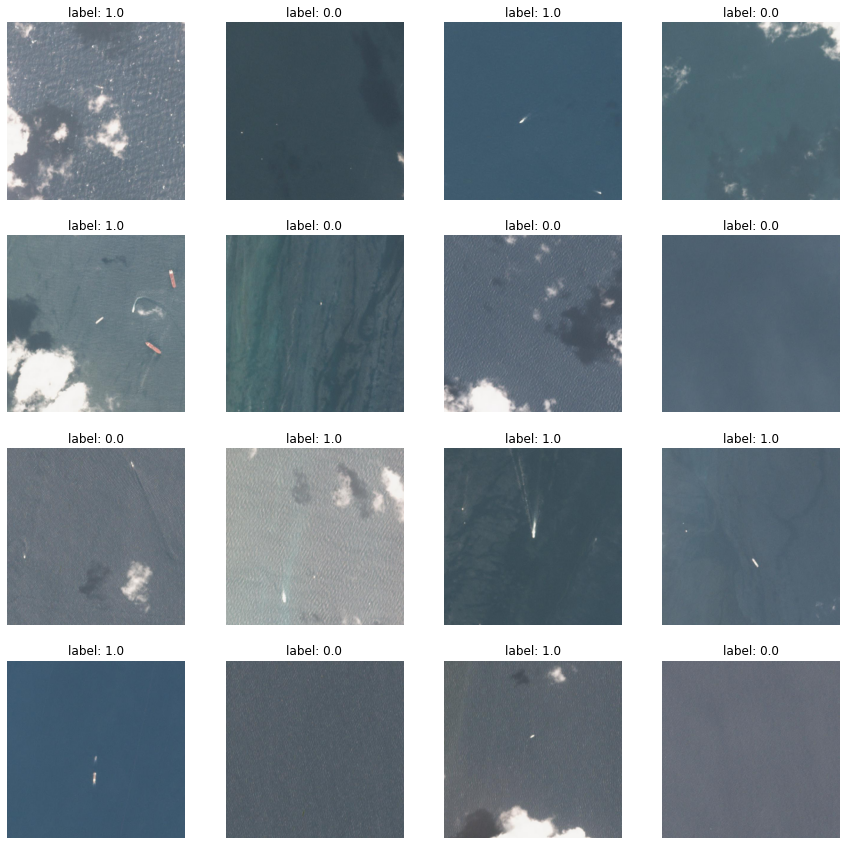

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf

viz_data_gen = image.ImageDataGenerator(rescale=1./255.)
viz_gen = viz_data_gen.flow_from_dataframe(df_data,
                                      directory=data_dir,
                                      x_col="filename",
                                      y_col="class",
                                      target_size=(img_height, img_width),
                                      batch_size=batch_size,
                                      class_mode='binary',
                                      shuffle=True)

images, labels = next(viz_gen)

s=4
fig, axs = plt.subplots(s,s, figsize=(15,15))

for e,i in enumerate(range(s*s)):
  img_title = 'label: ' + str(labels[i])
  axs[int(e/s)][e%s].imshow(images[i]), axs[int(e/s)][e%s].axis('off'), axs[int(e/s)][e%s].title.set_text(img_title)

plt.show()

## Define Model

In [8]:
from tensorflow import keras

def build_model():
  base_model = keras.applications.InceptionResNetV2(
      weights="imagenet",  # Load weights pre-trained on ImageNet.
      input_shape=(img_width, img_height, 3),
      include_top=False,
  )  # Do not include the ImageNet classifier at the top.

  # Freeze the base_model
  base_model.trainable = False

  # Create new model on top
  inputs = keras.Input(shape=(img_width, img_height, 3))
  x = inputs
  #x = data_augmentation(inputs)  # Apply random data augmentation

  # Pre-trained Xception weights requires that input be scaled
  # from (0, 255) to a range of (-1., +1.), the rescaling layer
  # outputs: `(inputs * scale) + offset`
  #scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  #x = scale_layer(x)


  # The base model contains batchnorm layers. We want to keep them in inference mode
  # when we unfreeze the base model for fine-tuning, so we make sure that the
  # base_model is running in inference mode here.
  x = base_model(x, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
  outputs = keras.layers.Dense(1, activation='softmax')(x)
  model = keras.Model(inputs, outputs)
  model.summary()
  
  return model
  

## Train

In [9]:
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score
import numpy as np

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#set up k-fold cross validation
kf = KFold(n_splits = num_splits, shuffle = True, random_state = None)

#variables that hold our test results across runs
y_preds = []
y_tests = []
tprs = []
aucs = []
f1s = []
mean_fpr = np.linspace(0, 1, 100)

fold = 1
for train_index, test_index in kf.split(df_data):
  print("FOLD " + str(fold))
  df_train = df_data.iloc[train_index]
  df_test = df_data.iloc[test_index]

  train_data_gen = image.ImageDataGenerator(rescale=1./255.,
                                       rotation_range=0.1,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest',
                                       validation_split=0.2)
  
  test_data_gen = image.ImageDataGenerator(rescale=1./255.)

  train_gen = train_data_gen.flow_from_dataframe(df_train,
                                      directory=data_dir,
                                      x_col="filename",
                                      y_col="class",
                                      target_size=(img_height, img_width),
                                      batch_size=batch_size,
                                      class_mode='binary',
                                      subset="training",
                                      shuffle=True)

  validation_gen = train_data_gen.flow_from_dataframe(df_train,
                                          directory=data_dir,
                                          x_col="filename",
                                          y_col="class",
                                          target_size=(img_height, img_width),
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          subset="validation",
                                          shuffle=True)
  test_gen = test_data_gen.flow_from_dataframe(df_test,
                                          directory=data_dir,
                                          x_col="filename",
                                          y_col="class",
                                          target_size=(img_height, img_width),
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          shuffle=False)
  
  #Freeze the base model and only train the extra layer
  model = build_model()

  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=[metrics.BinaryAccuracy(), f1_m],
  )
  
  #checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold), 
	#						monitor='val_accuracy', verbose=1, 
	#						save_best_only=True, mode='max')
  #callbacks = [checkpoint]
  callbacks = []
  
  model.fit(train_gen, epochs=20, validation_data=validation_gen, callbacks=callbacks)

  # Unfreeze the base_model and finetune whole model with low learning rate
  model.trainable = True
  model.summary()

  model.compile(
      optimizer=keras.optimizers.Adam(1e-5),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[keras.metrics.BinaryAccuracy(), f1_m],
  )

  model.fit(train_gen, epochs=10, validation_data=validation_gen)

  # test predictions and calculate test metrics
  y_pred = model.predict(test_gen).ravel().round().astype(int)
  y_test = df_test["class"].replace("ships", int(1)).replace("nonships", int(0)).ravel().astype(int)
  y_preds.append(y_pred)
  y_tests.append(y_test)

  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs.append(roc_auc_score(y_test, y_pred))
  f1s.append(f1_score(y_test, y_pred, average="binary"))

  print(y_pred)
  print(y_test)
  print(f1_score(y_test, y_pred, average="binary"))

  tf.keras.backend.clear_session()
  fold += 1

FOLD 1
Found 1120 validated image filenames belonging to 2 classes.
Found 280 validated image filenames belonging to 2 classes.
Found 351 validated image filenames belonging to 2 classes.
219070464/219055592 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 11, 11, 1536)     54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
    

## Plot ROC 

In [10]:
f1s

[0.6368932038834951,
 0.6940298507462687,
 0.6742424242424243,
 0.6407766990291262,
 0.6742424242424243]

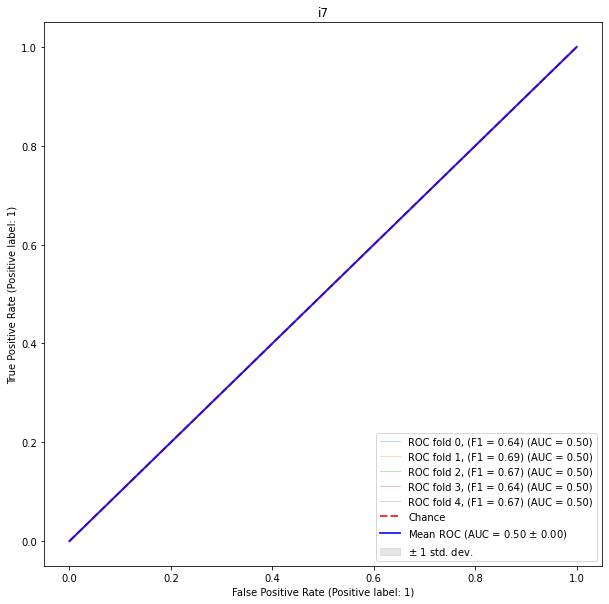

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(10,10))

for i in range(num_splits):
  viz = RocCurveDisplay.from_predictions(
        y_tests[i],
        y_preds[i],
        name="ROC fold {}, (F1 = {:.2f})".format(i, float(f1s[i])),
        alpha=0.3,
        lw=1,
        ax=ax)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=notebook_iteration,
)
ax.legend(loc="lower right")
plt.show()
